# Introduction to configuration space and collision checking

## Load and display a robot in an environment with obstacles

Do imports.

In [20]:
# Rigid body dynamics (pinocchio)
import pinocchio as pin

# Collision checking
import coal

# Visualization (meshcat)
from pinocchio.visualize import MeshcatVisualizer
import meshcat_shapes

# Robot models (robot_descriptions)
from robot_descriptions.loaders.pinocchio import load_robot_description

# Math ("expm" is the matrix exponential function)
import numpy as np
from scipy.linalg import expm, logm
from qpsolvers import solve_qp

# Timing
import time

# Plots
import matplotlib.pyplot as plt

# Interaction
import ipywidgets as widgets
from IPython.display import display
from tqdm.notebook import tqdm

# Other utilities
import itertools

# Suppress the display of very small numbers
np.set_printoptions(suppress=True)

Load a robot model and show how many joints there are.

In [21]:
# Load model
robot = load_robot_description(
    'iiwa14_description',           # name of robot model
    root_joint=None,                # fixed base
)

# Show number of joints
print(f'There are {robot.nq} joints.')

There are 7 joints.


Create a "reduced model" in which only two joints are free.

In [22]:
# List of joints that are free
unlocks = [1, 3]

robot.model, [
    robot.visual_model,
    robot.collision_model,
] = pin.buildReducedModel(
    robot.model,
    [robot.visual_model, robot.collision_model],
    [i + 1 for i in range(robot.nq) if i not in unlocks],
    robot.q0,
)

robot.data = robot.model.createData()
robot.collision_data = robot.collision_model.createData()
robot.visual_data = robot.visual_model.createData()
robot.q0 = robot.q0[unlocks].copy()

Add obstacles (this must be done before creating the display or doing anything else - otherwise, if you are not careful, you will likely get a kernel error).

In [23]:
# This code is from an example by Nicolas Mansard

# Define function that allows us to specify pose by xyz and rpy
def XYZRPYtoSE3(xyzrpy):
    rotate = pin.utils.rotate
    R = rotate("x", xyzrpy[3]) @ rotate("y", xyzrpy[4]) @ rotate("z", xyzrpy[5])
    p = np.array(xyzrpy[:3])
    return pin.SE3(R, p)

# Define the pose of each obstacle (a capsule)
oMobs = [
    [0.4, 0.0, 0.5, np.pi / 2, 0, 0],
    [-0.4, -0.0, 1.0, np.pi / 2, 0, 0],
    [-0.3, 0.0, 0.1, np.pi / 2, 0, 0],
]

# Add each obstacle to models
rad, length = 0.1, 0.4                                      # radius and length of each capsule
for i, xyzrpy in enumerate(oMobs):
    obs = pin.GeometryObject.CreateCapsule(rad, length)
    obs.meshColor = np.array([1.0, 0.2, 0.2, 1.0])
    obs.name = "obs%d" % i
    obs.parentJoint = 0                                     # this means the parent object is the universe
    obs.placement = XYZRPYtoSE3(xyzrpy)
    robot.collision_model.addGeometryObject(obs)
    robot.visual_model.addGeometryObject(obs)

# Create collision pairs (ignore self-collision)
nobs = len(oMobs)
nbodies = robot.collision_model.ngeoms - nobs
robotBodies = range(nbodies)
envBodies = range(nbodies, nbodies + nobs)
robot.collision_model.removeAllCollisionPairs()
for a, b in itertools.product(robotBodies, envBodies):
    robot.collision_model.addCollisionPair(pin.CollisionPair(a, b))

# Update both collision and visual data
robot.collision_data = pin.GeometryData(robot.collision_model)
robot.visual_data = pin.GeometryData(robot.visual_model)

If desired, replace all obstacles with convex meshes.

In [24]:
#######
# Define function to convert primitive geometries to convex meshes

def primitive_to_convex(shape, n=32):
    """
    Convert a coal primitive shape to a ConvexBase by sampling
    its surface, building a BVHModel from the points, and computing
    the convex hull.
    """
    if isinstance(shape, coal.Box):
        # half-extents
        x, y, z = shape.halfSide
        verts = np.array([
            [ x,  y,  z], [ x,  y, -z], [ x, -y,  z], [ x, -y, -z],
            [-x,  y,  z], [-x,  y, -z], [-x, -y,  z], [-x, -y, -z],
        ])

    elif isinstance(shape, coal.Cylinder):
        r = shape.radius
        h = shape.halfLength
        theta = np.linspace(0, 2 * np.pi, n, endpoint=False)
        circle = np.column_stack([r * np.cos(theta), r * np.sin(theta)])
        top = np.column_stack([circle, np.full(n, h)])
        bot = np.column_stack([circle, np.full(n, -h)])
        verts = np.vstack([top, bot])

    elif isinstance(shape, coal.Cone):
        r = shape.radius
        h = shape.halfLength
        theta = np.linspace(0, 2 * np.pi, n, endpoint=False)
        base = np.column_stack([r * np.cos(theta), r * np.sin(theta),
                                np.full(n, -h)])
        apex = np.array([[0.0, 0.0, h]])
        verts = np.vstack([base, apex])

    elif isinstance(shape, coal.Sphere):
        verts = _sphere_points(shape.radius, n)

    elif isinstance(shape, coal.Ellipsoid):
        rx, ry, rz = shape.radii
        unit = _sphere_points(1.0, n)
        verts = unit * np.array([rx, ry, rz])

    elif isinstance(shape, coal.Capsule):
        r = shape.radius
        h = shape.halfLength
        # hemisphere + cylinder ring
        unit = _sphere_points(1.0, n)
        top_hemi = unit[unit[:, 2] >= 0] * r + [0, 0, h]
        bot_hemi = unit[unit[:, 2] <= 0] * r + [0, 0, -h]
        theta = np.linspace(0, 2 * np.pi, n, endpoint=False)
        ring = np.column_stack([r * np.cos(theta), r * np.sin(theta),
                                np.zeros(n)])
        verts = np.vstack([top_hemi, bot_hemi,
                           ring + [0, 0, h], ring + [0, 0, -h]])

    else:
        raise TypeError(f"Unsupported shape type: {type(shape)}")

    return _points_to_convex(verts)


def _sphere_points(radius, n):
    """Fibonacci sphere sampling."""
    indices = np.arange(n * n // 2)  # enough points
    # Use a simpler grid approach
    u = np.linspace(0, 2 * np.pi, n, endpoint=False)
    v = np.linspace(0, np.pi, n // 2 + 1)
    theta, phi = np.meshgrid(u, v)
    theta, phi = theta.ravel(), phi.ravel()
    x = radius * np.sin(phi) * np.cos(theta)
    y = radius * np.sin(phi) * np.sin(theta)
    z = radius * np.cos(phi)
    return np.column_stack([x, y, z])


def _points_to_convex(points):
    """Build a BVHModel from a point cloud and compute its convex hull."""
    bvh = coal.BVHModelOBBRSS()
    bvh.beginModel(0, len(points))
    bvh.addVertices(points)
    bvh.endModel()
    bvh.buildConvexHull(True, "Qt")
    return bvh.convex

#
#######

# Apply function to all geometry objects in collision_model
for geom_obj in robot.collision_model.geometryObjects:
    geom = geom_obj.geometry
    if isinstance(geom, coal.ShapeBase):
        convex = primitive_to_convex(geom)
        geom_obj.geometry = convex
    elif isinstance(geom, coal.BVHModelBase):
        geom.buildConvexHull(True, "Qt")
        geom_obj.geometry = geom.convex

# Regenerate collision_data since collision_model has changed
robot.collision_data = robot.collision_model.createData()

Display robot (and obstacles) in browser.

In [25]:
# Create a visualizer
vis = MeshcatVisualizer(robot.model, robot.collision_model, robot.visual_model)
robot.setVisualizer(vis, init=False)
vis.initViewer(open=True)
vis.loadViewerModel()

# Pause to allow meshcat initialization to finish
time.sleep(0.1)

# Choose what to display
vis.displayFrames(False)
vis.displayVisuals(True)
vis.displayCollisions(False)

# Add our own frames to the visualizer because the default frames are hard to see
frames_to_show = [
    'iiwa_link_0',
    'iiwa_link_ee_kuka',
]
for frame in frames_to_show:
    meshcat_shapes.frame(vis.viewer['frames/' + frame], opacity=1.0, axis_length=0.2)

# Pause to allow meshcat initialization to finish
time.sleep(0.1)

# Change the camera view
vis.setCameraPosition(np.array([0., 2., 0.75]))
vis.setCameraTarget(np.array([0., 0., 0.75]))

You can open the visualizer by visiting the following URL:
http://127.0.0.1:7001/static/


Put the robot at its "neutral" configuration.

In [26]:
# # Get and show the neutral configuration (most likely all zeros)
q = pin.neutral(robot.model)
print(f'{q = }')

# Do forward kinematics
# - Compute the placement of all joint frames (modifies robot.data but not robot.model or q)
pin.forwardKinematics(robot.model, robot.data, q)
# - Compute the placement of all link frames (modifies robot.data but not robot.model)
pin.updateFramePlacements(robot.model, robot.data)

# Show the configuration in the visualizer
vis.display(q)
for frame in frames_to_show:
    frame_id = robot.model.getFrameId(frame)
    vis.viewer['frames/' + frame].set_transform(robot.data.oMf[frame_id].homogeneous)

q = array([0., 0.])


Create sliders that allow us to change the configuration.

In [27]:
# Callback function that receives all slider values
def on_slider_change(change):
    global q
    q = np.deg2rad(np.array([slider.value for slider in sliders]))
    pin.forwardKinematics(robot.model, robot.data, q)
    pin.updateFramePlacements(robot.model, robot.data)
    vis.display(q)
    for frame in frames_to_show:
        frame_id = robot.model.getFrameId(frame)
        vis.viewer['frames/' + frame].set_transform(robot.data.oMf[frame_id].homogeneous)

# Create sliders for each joint
sliders = []
for i in range(robot.nq):
    slider = widgets.FloatSlider(
        value=0,
        min=-180,
        max=180,
        step=0.1,
        description=f'Joint {i+1}:',
        continuous_update=True,  # Only update on release
        orientation='horizontal',
        readout=True,
        readout_format='.1f',
        layout=widgets.Layout(width='600px')  # Set slider width
    )
    # Attach the same callback to each slider
    slider.observe(on_slider_change, names='value')
    sliders.append(slider)

# Display all sliders
display(widgets.VBox(sliders))

# Initialize robot
on_slider_change(None)

Switch from showing "visual" geometry to showing "collision" geometry.

In [28]:
vis.displayVisuals(False)
vis.displayCollisions(True)

Define functions to check for collision, either returning true / false or returning the distance to collision in the workspace.

In [10]:
def boolean_collision(q):
    pin.updateGeometryPlacements(
        robot.model,
        robot.data,
        robot.collision_model,
        robot.collision_data,
        q)
    return pin.computeCollisions(robot.collision_model, robot.collision_data, False)

def distance_collision(q):
    if boolean_collision(q):
        return 0.
    else:
        # Compute the distance between each collision pair and
        # get the index of the pair with the smallest distance
        idx = pin.computeDistances(robot.collision_model, robot.collision_data)
        # Return that smallest distance
        return robot.collision_data.distanceResults[idx].min_distance

Exhaustively compute the free space by sampling the configuration space on a uniform grid.

In [29]:
# Define function to sample one joint angle uniformly
# from its lower limit to its upper limit
def sample_q_uniformly(model, idx, res=0.1):
    qmin = model.lowerPositionLimit[idx]
    qmax = model.upperPositionLimit[idx]
    n = int(np.ceil((qmax - qmin) / res))
    return np.linspace(qmin, qmax, n)

# Sample on uniform grid
Q1, Q2 = np.meshgrid(
    sample_q_uniformly(robot.model, 0, res=0.025),
    sample_q_uniformly(robot.model, 1, res=0.025),
)

# Compute distance to collision at each sample
D = np.zeros_like(Q1)
with tqdm(total=Q1.shape[1], desc='Processing') as pbar:
    for i in range(Q1.shape[1]):
        for j in range(Q1.shape[0]):
            q = np.array([Q1[j, i], Q2[j, i]])
            D[j, i] = distance_collision(q)
        pbar.update(1)

Processing:   0%|          | 0/168 [00:00<?, ?it/s]

Create sliders again, but show the configuration space this time.

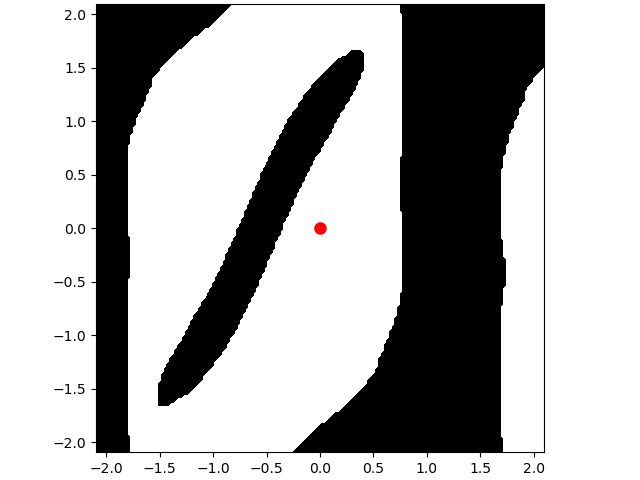

[0. 0.]


In [12]:
# Enable interactive plots
%matplotlib widget

# Create and show plot of configuration space
fig, ax = plt.subplots(layout='constrained')
c = ax.contourf(Q1, Q2, D, levels=[0., 1e-8, 1.], colors=['black', 'white'])
ax.set_aspect('equal')
red_dot, = ax.plot([0.], [0.], 'ro', markersize=8)
plt.show()

# Define callback function to handle changes to slider values
def on_slider_change(change):
    global q
    q = np.array([slider.value for slider in sliders])
    print(q)
    pin.forwardKinematics(robot.model, robot.data, q)
    pin.updateFramePlacements(robot.model, robot.data)
    vis.display(q)
    for frame in frames_to_show:
        frame_id = robot.model.getFrameId(frame)
        vis.viewer['frames/' + frame].set_transform(robot.data.oMf[frame_id].homogeneous)
    red_dot.set_data([q[0]], [q[1]])
    if boolean_collision(q):
        red_dot.set_color('r')
    else:
        red_dot.set_color('c')
    fig.canvas.draw_idle()

# Create sliders for each joint
sliders = []
for i in range(robot.nq):
    slider = widgets.FloatSlider(
        value=0.,
        min=robot.model.lowerPositionLimit[i],
        max=robot.model.upperPositionLimit[i],
        step=0.002,
        description=f'Joint {i+1}:',
        continuous_update=True,
        orientation='horizontal',
        readout=True,
        readout_format='.1f',
        layout=widgets.Layout(width='600px')
    )
    slider.observe(on_slider_change, names='value')
    sliders.append(slider)

# Show sliders
display(widgets.VBox(sliders))

# Do the callback once to initialize everything
on_slider_change(None)

## Show how to do collision checking by solving a QP

Show all collision pairs.

In [13]:
for i, pair in enumerate(robot.collision_model.collisionPairs):
    print(f'{i:2d} : {pair.first:2d} x {pair.second:2d} ({robot.collision_model.geometryObjects[pair.first].name} x {robot.collision_model.geometryObjects[pair.second].name})')

 0 :  0 x  8 (iiwa_link_0_0 x obs0)
 1 :  0 x  9 (iiwa_link_0_0 x obs1)
 2 :  0 x 10 (iiwa_link_0_0 x obs2)
 3 :  1 x  8 (iiwa_link_1_0 x obs0)
 4 :  1 x  9 (iiwa_link_1_0 x obs1)
 5 :  1 x 10 (iiwa_link_1_0 x obs2)
 6 :  2 x  8 (iiwa_link_2_0 x obs0)
 7 :  2 x  9 (iiwa_link_2_0 x obs1)
 8 :  2 x 10 (iiwa_link_2_0 x obs2)
 9 :  3 x  8 (iiwa_link_3_0 x obs0)
10 :  3 x  9 (iiwa_link_3_0 x obs1)
11 :  3 x 10 (iiwa_link_3_0 x obs2)
12 :  4 x  8 (iiwa_link_4_0 x obs0)
13 :  4 x  9 (iiwa_link_4_0 x obs1)
14 :  4 x 10 (iiwa_link_4_0 x obs2)
15 :  5 x  8 (iiwa_link_5_0 x obs0)
16 :  5 x  9 (iiwa_link_5_0 x obs1)
17 :  5 x 10 (iiwa_link_5_0 x obs2)
18 :  6 x  8 (iiwa_link_6_0 x obs0)
19 :  6 x  9 (iiwa_link_6_0 x obs1)
20 :  6 x 10 (iiwa_link_6_0 x obs2)
21 :  7 x  8 (iiwa_link_7_0 x obs0)
22 :  7 x  9 (iiwa_link_7_0 x obs1)
23 :  7 x 10 (iiwa_link_7_0 x obs2)


Pick a collision pair to use as an example.

In [14]:
i_pair = 16

From normals and offsets, get a description

$$ A x \leq b $$

of the halfspaces that define each convex mesh in the collision pair.

In [30]:
def get_halfspaces(model, data, i):
    normals = model.geometryObjects[i].geometry.normals()
    offsets = model.geometryObjects[i].geometry.offsets()
    R = data.oMg[i].rotation
    p = data.oMg[i].translation
    A = np.array([R @ a for a in normals])
    b = - np.array([b + np.dot(a, R.T @ p) for a, b in zip(normals, offsets)])
    return A, b

A1, b1 = get_halfspaces(
    robot.collision_model,
    robot.collision_data,
    robot.collision_model.collisionPairs[i_pair].first,
)

A2, b2 = get_halfspaces(
    robot.collision_model,
    robot.collision_data,
    robot.collision_model.collisionPairs[i_pair].second,
)

Compute the distance between the two meshes in the collision pair by solving a quadratic program. Remember that `solve_qp` expects the QP to be expressed in the following form:

$$
\begin{align*}
\underset{x\in\R^n}{\text{minimize}} &\qquad \frac{1}{2}x^TPx + q^Tx \\
\text{subject to} &\qquad Gx \leq h \\
&\qquad Ax=b \\
&\qquad x_\text{min} \leq x \leq x_\text{max}.
\end{align*}
$$

In [16]:
# Set up objective and constraints
M = np.hstack([np.identity(3), -np.identity(3)])
G = np.block([[A1, np.zeros((A1.shape[0], A2.shape[1]))],
              [np.zeros((A2.shape[0], A1.shape[1])), A2]])
h = np.concatenate([b1, b2])

# Solve
x = solve_qp(2. * M.T @ M, np.zeros(6), G, h, solver='proxqp', verbose=False)

# Parse solution
x1 = x[:3]
x2 = x[3:]

# Get minimum distance
d = np.linalg.norm(x2 - x1)

Compute the same distance using pinocchio.

In [17]:
d_pin = pin.computeDistance(robot.collision_model, robot.collision_data, i_pair).min_distance

Compare results (note what happens when in collision).

In [18]:
print(f'  by hand: {d:7.4f}')
print(f'pinocchio: {d_pin:7.4f}')

assert(np.isclose(d, d_pin))

  by hand:  0.2300
pinocchio:  0.2300
